# Training pipeline


### 0. import

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from tqdm import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### 1. Configuration

##### path & format


In [ ]:
# 1. 基本參數設定
NUM_CLASSES_DETAILED = 12 # Detailed (12類): 0:BG, 1:SA, 2:RF, 3:VL, 4:VI, 5:VM, 6:AM, 7:GR, 8:BFL, 9:ST, 10:SM, 11:BFS
NUM_CLASSES_ROUGH = 5 # Rough (5類): 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 0
PIN_MEMORY = True

# 2. 資料路徑
PROJECT_ROOT = "/home/n26141826/114-1_TAICA_cv_Final_Project"
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "npy_Embedding")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints", "checkpoints_3step_256_hybridLoss")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results" ,"results_3step_256_hybridLoss")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train") 
TEST_DATA_DIR = os.path.join(DATA_DIR, "test")

# 3. 模型存檔路徑 (Model Checkpoints)
ROUGH_MODEL_PATH  = os.path.join(CHECKPOINT_DIR, "rough_model_best.pth")
WARMUP_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "warmup_model.pth")
DETAIL_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "detail_model_best.pth")
EVAL_MODEL_PATH   = DETAIL_MODEL_PATH

# 4. train loss / val loss 紀錄路徑
ROUGH_LOSS_LOG  = os.path.join(RESULTS_DIR, "rough_loss.csv")
ROUGH_LOSS_IMG   = os.path.join(RESULTS_DIR, "rough_loss.png")
WARMUP_LOSS_LOG = os.path.join(RESULTS_DIR, "warmup_loss.csv")
WARMUP_LOSS_IMG  = os.path.join(RESULTS_DIR, "warmup_loss.png")
DETAIL_LOSS_LOG = os.path.join(RESULTS_DIR, "detail_loss.csv")
DETAIL_LOSS_IMG  = os.path.join(RESULTS_DIR, "detail_loss.png")


# 5. 評估輸出路徑
EVAL_CSV_OUTPUT = os.path.join(RESULTS_DIR, "evaluation_metrics_per_sequence.csv")
FLATTENED_METRICS_OUTPUT = os.path.join(RESULTS_DIR, "flattened_metrics.csv")

# 模型架構參數 (Model Architecture)
IN_CHANNELS = 1        # 輸入影像通道數 (灰階)
EMBEDDING_DIM = 64     # 條件向量 (Type/Pos) 的維度
NUM_MRI_TYPES = 5      # MRI 序列總數 (Water, Fat, T1, T2, STIR)

# 視覺化設定
VIZ_INTERVAL = 50

print(f"✅ Configuration Loaded!")
print(f"   - Device     : {DEVICE}")
print(f"   - Data       : {DATA_DIR}")
print(f"   - Checkpoints: {CHECKPOINT_DIR}")
print(f"   - Results    : {RESULTS_DIR}")

#### Training Hyper-parameter

In [ ]:
TARGET_SIZE = 256
# 幾何變換 (Joint Transform: Image + Label)
AUG_P_FLIP = 0.5          # 左右翻轉的機率
AUG_P_SCALE = 0.5         # 隨機縮放的機率
AUG_LIMIT_SCALE = 0.1     # 縮放幅度 (0.1 代表 0.9x ~ 1.1x)

# 像素變換 (Independent Transform: Image Only)
AUG_P_BRIGHTNESS = 0.5    # 亮度/對比度調整機率
AUG_LIMIT_BRIGHT = 0.2    # 亮度調整幅度 (+-20%)
AUG_LIMIT_CONTRAST = 0.2  # 對比度調整幅度 (+-20%)

# Pre-train (Rough)
ROUGH_BATCH_SIZE = 16
ROUGH_LR = 1e-3
ROUGH_EPOCHS = 50

# Hierarchical Warm-up (Detail Head Warm-up)
WARMUP_BATCH_SIZE = 16    # 使用 Detail Data，通常量較少或需較小 Batch
WARMUP_LR = 1e-3          # 只訓練 Head，可以用大一點的 LR
WARMUP_EPOCHS = 10        # 短暫熱身即可
# 控制 Student(Detail) 模仿 Teacher(Rough) 的強度
# 建議範圍: 0.1 ~ 1.0
CONSISTENCY_WEIGHT = 0.5

# Fine-tune (Detail)
DETAIL_BATCH_SIZE = 16
DETAIL_EPOCHS = 75
DETAIL_LR_ENCODER = 1e-5 # Encoder 慢慢修 (微整形)
DETAIL_LR_DECODER = 1e-4 # Decoder 正常學

# Mappings & Definitions
ROUGH_MAP = [0, 1, 2, 2, 2, 2, 0, 3, 4, 4, 4, 4]  # 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
# MRI 序列映射表 (Modality Mapping)
TYPE_MAP = {
    'Water': 0,
    'FATFRACTION': 1, # 通常將 Fat Fraction 視為 Fat 類別，或依你需求改為獨立 ID
    'Fat': 1,
    'T1': 2,
    'T2': 3,
    'STIR': 4
}
ID_TO_TYPE = {v: k for k, v in TYPE_MAP.items()}

# 定義映射矩陣 (12類 -> 5類)
# 0:BG, 1:SA, 2:RF, 3:VL, 4:VI, 5:VM, 6:AM, 7:GR, 8:BFL, 9:ST, 10:SM, 11:BFS
# Map to: 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
MAPPING_MATRIX = torch.tensor([
    [1, 0, 0, 0, 0], # 0->0
    [0, 1, 0, 0, 0], # 1->1
    [0, 0, 1, 0, 0], # 2->2
    [0, 0, 1, 0, 0], # 3->2
    [0, 0, 1, 0, 0], # 4->2
    [0, 0, 1, 0, 0], # 5->2
    [1, 0, 0, 0, 0], # 6->0 (AM -> BG)
    [0, 0, 0, 1, 0], # 7->3
    [0, 0, 0, 0, 1], # 8->4
    [0, 0, 0, 0, 1], # 9->4
    [0, 0, 0, 0, 1], # 10->4
    [0, 0, 0, 0, 1]  # 11->4
], dtype=torch.float32).to(DEVICE)

# Evaluation Configuration
EVAL_BATCH_SIZE = 1
# 2. 肌肉名稱對照表 (1-11)
MUSCLE_NAMES = {
    1: 'Sartorius',
    2: 'Rectus Femoris',
    3: 'Vastus Lateralis',
    4: 'Vastus Intermedius',
    5: 'Vastus Medialis',
    6: 'Adductor Magnus',
    7: 'Gracilis',
    8: 'Biceps Femoris LH',
    9: 'Semitendinosus',
    10: 'Semimembranosus',
    11: 'Biceps Femoris SH'
}
# 3. 視覺化顏色設定 (Visualization Colors)
VIZ_COLORS = [
    '#000000', '#e6194b', '#006400', '#228B22', '#32CD32', '#7CFC00', 
    '#911eb4', '#46f0f0', '#00008B', '#0000CD', '#4169E1', '#87CEEB'
]
colors_list = list(VIZ_COLORS)
colors_list[0] = (0, 0, 0, 0)
VIZ_CMAP = mcolors.ListedColormap(colors_list)
# VIZ_CMAP = mcolors.ListedColormap(VIZ_COLORS)
VIZ_NORM = mcolors.BoundaryNorm(boundaries=np.arange(13)-0.5, ncolors=12)

### 2. Utilities

In [ ]:
# --- Metrics (為了跟組員比對，使用標準 Dice) ---
def dice_score(preds, targets, num_classes):
    # 簡單的 Dice 計算範例，組員可能有更複雜的版本，可替換
    dice_list = []
    preds = torch.argmax(preds, dim=1)
    
    for cls in range(1, num_classes): # Skip background
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        
        score = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_list.append(score.item())
        
    return np.mean(dice_list)

def plot_training_curves(log_path, image_path=None):
    """
    讀取 CSV Log 並畫出 Loss 和 Dice 曲線，
    使用 clear_output 達成即時刷新效果。
    """
    if not os.path.exists(log_path):
        return

    # 讀取數據
    try:
        df = pd.read_csv(log_path)
    except pd.errors.EmptyDataError:
        return

    # 設定畫布 (左邊 Loss, 右邊 Dice)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # --- 1. Loss Curve ---
    ax1.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o', color='tab:blue')
    ax1.plot(df['epoch'], df['val_loss'], label='Val Loss', marker='o', color='tab:orange')
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    # --- 2. Dice Curve ---
    if 'val_dice' in df.columns:
        ax2.plot(df['epoch'], df['val_dice'], label='Val Dice', marker='o', color='tab:green')
        ax2.set_title("Validation Dice Score")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Dice")
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.legend()
        
        # 標出目前的最高分
        max_dice = df['val_dice'].max()
        max_epoch = df.loc[df['val_dice'].idxmax(), 'epoch']
        ax2.annotate(f'Max: {max_dice:.4f}', xy=(max_epoch, max_dice), 
                     xytext=(max_epoch, max_dice - 0.05),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    if image_path:
        plt.savefig(image_path)
    
    # 清除上一次的圖並顯示新的
    clear_output(wait=True)
    plt.show()

### 2. Train - validation split

In [5]:
# 1. 搜尋所有 .npy 檔案
all_files = glob.glob(os.path.join(TRAIN_DATA_DIR, "*.npy"))
print(f"Total .npy files found in train data: {len(all_files)}")

# 2. 依照 Subject 分類
train_files = []
val_files = []
train_detail = []
train_without_detail = []
for i in all_files:
    data = np.load(i, allow_pickle=True).item()
    if data.get('has_detail'):
        train_detail.append(i)
    else:
        train_without_detail.append(i)
# --- split rough only training data & val ---
train_roughonly_subs, val_roughonly_subs = train_test_split(
    train_without_detail, test_size=0.1, random_state=42
)
# --- split detail training data & val ---
train_detail_subs, val_detail_subs = train_test_split(
    train_detail, test_size=0.1, random_state=42
)
# --- combine ---
train_files = train_roughonly_subs + train_detail_subs
val_files = val_roughonly_subs + val_detail_subs
# --- 計算 Train 分佈 ---
train_rough_seq_distribution = {}
for i in train_files:
    data = np.load(i, allow_pickle=True).item()
    key = data.get('type_idx')
    if key not in train_rough_seq_distribution:
        train_rough_seq_distribution[key] = 0
    train_rough_seq_distribution[key] += 1
# --- 計算 Val 分佈 ---
val_rough_seq_distribution = {}
for i in val_files:
    data = np.load(i, allow_pickle=True).item()
    key = data.get('type_idx')
    if key not in val_rough_seq_distribution:
        val_rough_seq_distribution[key] = 0
    val_rough_seq_distribution[key] += 1
# --- log ---
print("-"*30)
print(f"Train Files : {len(train_files)}")
print(f"Val Files   : {len(val_files)}")
print("-"*30)

# --- measure type distribution ---
# 1. 找出所有出現過的類別 ID (取聯集並排序)
all_keys = sorted(set(train_rough_seq_distribution.keys()) | set(val_rough_seq_distribution.keys()))

# 2. 準備資料字典
data = {}
for k in all_keys:
    # 取得類別名稱
    seq_name = ID_TO_TYPE.get(k, f"Unknown({k})")
    
    # 取得 Train 和 Val 的數量
    train_count = train_rough_seq_distribution.get(k, 0)
    val_count = val_rough_seq_distribution.get(k, 0)
    
    # 計算比率 (Val / Train)
    ratio = val_count / train_count if train_count > 0 else 0.0
    
    # 存入字典
    data[seq_name] = [train_count, val_count, ratio]

# 3. 轉成 DataFrame
df_dist = pd.DataFrame.from_dict(data, orient='index', columns=['Train', 'Val', 'Val : Train'])

# 4. 加入 Total 總和列
total_train = df_dist['Train'].sum()
total_val = df_dist['Val'].sum()
total_ratio = total_val / total_train if total_train > 0 else 0.0

df_dist.loc['Total'] = [total_train, total_val, total_ratio]

# 5. 格式化顯示 (顯示百分比可能會更直觀)
styled_df = df_dist.style.format({
    'Train': '{:,.0f}',       # 整數
    'Val': '{:,.0f}',         # 整數
    'Val : Train': '{:.1%}'   # 轉成百分比 (例如 0.11 -> 11.0%)
})
display(styled_df)

------------------------------
Train Files : 10521
Val Files   : 1170
------------------------------


,Train,Val,Val : Train
Water,"2,400",252,10.5%
Fat,"5,350",606,11.3%
T1,"1,512",174,11.5%
T2,694,74,10.7%
STIR,565,64,11.3%
Total,"10,521","1,170",11.1%


### 3. Dataset

In [6]:
class SliceMasterDataset(Dataset):
    def __init__(self, file_list, mode='rough', transform=None):
        """
        Args:
            file_list (list): List of .npy file paths
            mode (str): 'rough' or 'detail'
            transform: Albumentations transform
        """
        self.file_list = file_list
        self.mode = mode
        self.transform = transform
        # Rough Map (12 -> 5)
        self.rough_map = np.array(ROUGH_MAP, dtype=np.uint8)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 1. Load Dictionary
        data = np.load(self.file_list[idx], allow_pickle=True).item()
        
        image = data['image'] # (H, W) float32
        z_pos = data['z_pos']
        type_idx = data['type_idx']

        # 2. Select Label
        if self.mode == 'rough':
            label = data['rough_label']
        elif self.mode == 'detail':
            label = data['detail_label']
            # 如果是 Detail 模式但沒有標註，這張圖應該被過濾或 Loss Masking
            # 這裡簡單處理：如果全黑則視為背景
        
        # 3. Augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']
        
        # 4. To Tensor
        if isinstance(image, np.ndarray):
            if image.ndim == 2: 
                image = image[np.newaxis, ...] # (1, H, W)
            image = image.copy()
            
        if isinstance(label, np.ndarray):
            label = label.copy()

        return (
            torch.from_numpy(image).float(),
            torch.from_numpy(label).long(),
            torch.tensor(z_pos).float(),
            torch.tensor(type_idx).long()
        )

### 3. Transform

In [7]:
train_transform = A.Compose([
            A.Rotate(limit=15, p=0.5),      # 隨機旋轉 +/- 15度
            A.HorizontalFlip(p=0.5),        # 水平翻轉
            #A.VerticalFlip(p=0.1),          # 垂直翻轉 (比較少見但可增加難度)
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2), # 隨機縮放與位移
            A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=1)
        ])
# train_transform = A.Compose([
#     # 1. Independent Transform (只改 Image 不影響座標)
#     A.RandomBrightnessContrast(
#         brightness_limit=AUG_LIMIT_BRIGHT,  # 亮度
#         contrast_limit=AUG_LIMIT_CONTRAST,  # 對比度
#         p=AUG_P_BRIGHTNESS
#     ),
#     # (可選) 高斯雜訊
#     # A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),

#     # 2. Joint Transform (Image 與 Label 同步)
#     A.HorizontalFlip(p=AUG_P_FLIP),   # 左右翻轉 (Horizontal Flip)
#     A.RandomScale(scale_limit=AUG_LIMIT_SCALE, p=AUG_P_SCALE), # 隨機縮放 (Zoom In/Out)
    
#     # 3. Resize
#     A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=1),
# ])

# 驗證集：只做 Resize，不做任何隨機增強
val_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=1)
])

/home/n26141826/114-1_TAICA_cv_Final_Project/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### 4. Model Architecture

#### main model (Conditioned U-Net)

In [8]:
class ConditionedUNet(nn.Module):
    def __init__(self, n_channels=1, n_classes_rough=5, n_classes_detail=12, embed_dim=64, num_mri_types=5):
        super().__init__()
        
        # --- Standard Encoder (Simplified) ---
        # 建議：如果公版用 segmentation_models_pytorch (smp)，我們可以繼承它並修改 forward
        # 這裡手寫一個簡單版示意
        self.inc = self._block(n_channels, 64)
        self.down1 = self._block(64, 128)
        self.down2 = self._block(128, 256)
        self.down3 = self._block(256, 512)
        self.down4 = self._block(512, 1024) 
        
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # --- Embedding Layers (Key Difference) ---
        self.type_emb = nn.Embedding(num_embeddings=num_mri_types, embedding_dim=embed_dim)
        self.pos_emb = nn.Sequential(
            nn.Linear(1, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim)
        )
        
        # --- Fusion Layer ---
        # 將 Image Features (1024) + Type (64) + Pos (64) 融合回 1024
        self.fusion = nn.Sequential(
            nn.Conv2d(1024 + embed_dim*2, 1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # --- Decoder ---
        self.up1 = self._block(1024 + 512, 512)
        self.up2 = self._block(512 + 256, 256)
        self.up3 = self._block(256 + 128, 128)
        self.up4 = self._block(128 + 64, 64)
        
        # --- [關鍵] Dual Heads ---
        self.head_rough = nn.Conv2d(64, n_classes_rough, kernel_size=1)   # Phase 1 Target
        self.head_detail = nn.Conv2d(64, n_classes_detail, kernel_size=1) # Phase 2 Target

    def _block(self, in_c, out_c):
        """Standard Double Conv Block"""
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )

    def forward(self, x, type_idx, z_pos, return_mode='both'):
        """
        Args:
            return_mode: 'rough', 'detail', or 'both'
        """
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(self.pool(x1))
        x3 = self.down2(self.pool(x2))
        x4 = self.down3(self.pool(x3))
        x5 = self.down4(self.pool(x4)) # (B, 1024, H/16, W/16)
        
        # Injection
        # 1. 取得條件向量
        t_vec = self.type_emb(type_idx) # (B, 64)
        p_vec = self.pos_emb(z_pos.unsqueeze(1)) # (B, 64)
        
        # 2. 串接條件
        cond = torch.cat([t_vec, p_vec], dim=1) # (B, 128)
        
        # 3. 空間廣播 (Expand to Spatial dims)
        cond = cond.unsqueeze(2).unsqueeze(3).expand(-1, -1, x5.shape[2], x5.shape[3])
        
        # 4. 特徵融合
        x5 = torch.cat([x5, cond], dim=1)
        x5 = self.fusion(x5)
        
        # Decoder
        x = self.up1(torch.cat([self.up(x5), x4], dim=1))
        x = self.up2(torch.cat([self.up(x), x3], dim=1))
        x = self.up3(torch.cat([self.up(x), x2], dim=1))
        x = self.up4(torch.cat([self.up(x), x1], dim=1))
        
        # --- Heads ---
        if return_mode == 'rough':
            return self.head_rough(x)
        elif return_mode == 'detail':
            return self.head_detail(x)
        elif return_mode == 'both':
            return self.head_rough(x), self.head_detail(x)
        else:
            raise ValueError(f"Invalid return_mode: {return_mode}")
        
    def load_pretrained_encoder(self, weight_path):
        """載入權重，自動過濾不匹配的層"""
        if not os.path.exists(weight_path):
            print(f"⚠️ Path {weight_path} not found. Skipping.")
            return
            
        print(f"🔄 Loading weights from: {weight_path}")
        # map_location='cpu' 避免 GPU 記憶體激增
        pretrained_dict = torch.load(weight_path, map_location='cpu')
        model_dict = self.state_dict()
        
        # 過濾形狀不符的層
        filtered_dict = {k: v for k, v in pretrained_dict.items() 
                         if k in model_dict and v.shape == model_dict[k].shape}
        
        model_dict.update(filtered_dict)
        self.load_state_dict(model_dict)
        print(f"✅ Weights loaded! ({len(filtered_dict)} layers matched)")
        
    def freeze_encoder_and_rough(self):
        """Phase 1.5: Freeze everything except detail head"""
        print("🔒 Freezing Encoder layers...")
        for param in self.parameters(): param.requires_grad = False
        for param in self.head_detail.parameters(): param.requires_grad = True
        print("🔒 Frozen Encoder & Rough Head. Only 'head_detail' is trainable.")
                
        print("✅ Encoder frozen.")
    
    def unfreeze_all(self):
        """Phase 2: Unfreeze all"""
        for param in self.parameters(): param.requires_grad = True
        print("🔓 All layers unfrozen.")

#### Fine-tune Optimizer Design

##### Differential Learning Rates

In [9]:
# [Fine-tune Strategy Design] (Differential Learning Rates)
def get_fine_tuning_optimizer(model, encoder_lr=1e-5, decoder_lr=1e-4):
    """
    為 Fine-tuning 設計的優化器設定：
    1. Encoder 使用極小的 LR (保留 Pre-train 知識，但允許微調) -> Post-train 效果
    2. Decoder/Head 使用較大的 LR (快速學習 12 類特徵)
    """
    
    # 區分參數群組
    encoder_params = []
    decoder_params = []
    
    # 定義哪些層屬於 Encoder (根據 ConditionedUNet 結構)
    encoder_layers = ['inc', 'down1', 'down2', 'down3', 'down4', 'type_emb', 'pos_emb', 'fusion']
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
            
        # 判斷參數屬於 Encoder 還是 Decoder
        is_encoder = any(layer in name for layer in encoder_layers)
        
        if is_encoder:
            encoder_params.append(param)
        else:
            decoder_params.append(param) # up1, up2, up3, up4, outc
            
    print(f"🔧 Optimizer Groups Setup:")
    print(f"   - Encoder Params: {len(encoder_params)} tensors (LR={encoder_lr}) -> Slow updates")
    print(f"   - Decoder Params: {len(decoder_params)} tensors (LR={decoder_lr}) -> Fast learning")

    # 建立優化器
    optimizer = torch.optim.Adam([
        {'params': encoder_params, 'lr': encoder_lr},
        {'params': decoder_params, 'lr': decoder_lr}
    ])
    
    return optimizer

# --- 測試一下 (Optional) ---
# dummy_model = ConditionedUNet(1, 12).to(DEVICE)
# opt = get_fine_tuning_optimizer(dummy_model)

#### mapping matrix

In [10]:
def hierarchical_consistency_loss(logits_detail, logits_rough):
    """
    計算一致性 Loss:
    將 Detailed 預測透過 Mapping 聚合後，應該要跟 Rough 預測很像。
    """
    # 1. 將 Logits 轉為機率分佈 (Softmax)
    probs_detail = F.softmax(logits_detail, dim=1) # (B, 12, H, W)
    probs_rough = F.softmax(logits_rough, dim=1)   # (B, 5, H, W)
    
    # 2. 執行 Mapping (矩陣乘法)
    # 調整維度以進行矩陣乘法: (B, H, W, 12) x (12, 5) -> (B, H, W, 5)
    probs_detail_permuted = probs_detail.permute(0, 2, 3, 1) 
    probs_projected = torch.matmul(probs_detail_permuted, MAPPING_MATRIX)
    
    # 轉回 (B, 5, H, W)
    probs_projected = probs_projected.permute(0, 3, 1, 2)
    
    # 3. 計算兩分佈之間的差異 (KL Divergence 或 MSE)
    # 這裡用 MSE 簡單直觀：希望投影後的機率分布 = 原始 Rough 機率分布
    loss = F.mse_loss(probs_projected, probs_rough)
    
    return loss

### DiceCEloss

In [11]:
class OrthogonalBoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # 定義 Sobel 算子 (邊緣檢測卷積核)
        # 使用 reshape 確保維度為 (Out_channels, In_channels, H, W) -> (1, 1, 3, 3)
        kx = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).reshape(1, 1, 3, 3)
        ky = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).reshape(1, 1, 3, 3)
        
        # [關鍵優化] 使用 register_buffer
        # 這樣當你呼叫 model.to(device) 時，這兩個 kernel 會自動跟著移動到 GPU
        # 不需要再 forward 裡面手動 .to(device)
        self.register_buffer('kernel_x', kx)
        self.register_buffer('kernel_y', ky)

    def forward(self, pred, gt):
        """
        pred: (B, C, H, W) -> 模型輸出的 Logits
        gt: (B, H, W) -> Ground Truth Labels
        """
        num_classes = pred.shape[1]
        
        # 1. 處理 GT: One-hot Encoding
        # permute 會導致記憶體不連續，所以後續必須用 reshape
        gt_onehot = F.one_hot(gt, num_classes).permute(0, 3, 1, 2).float()
        
        # 2. 處理 Pred: 轉成機率分佈
        pred_prob = F.softmax(pred, dim=1)
        
        # 3. 準備卷積輸入
        # 我們要把 (B, C, H, W) 視為 B*C 個獨立的單通道圖片來做邊緣檢測
        b, c, h, w = pred.shape
        
        # [關鍵優化] 使用 .reshape()
        # 它能自動處理 permute 造成的非連續記憶體問題，比 .view() 更安全
        pred_reshaped = pred_prob.reshape(-1, 1, h, w) 
        gt_reshaped = gt_onehot.reshape(-1, 1, h, w)
        
        # 4. 卷積運算 (提取邊界)
        # 這裡直接用 self.kernel_x，因為它已經在正確的 device 上了
        pred_gx = F.conv2d(pred_reshaped, self.kernel_x, padding=1)
        pred_gy = F.conv2d(pred_reshaped, self.kernel_y, padding=1)
        # 計算梯度大小 (Gradient Magnitude)
        pred_grad = torch.sqrt(pred_gx**2 + pred_gy**2 + 1e-6)
        
        gt_gx = F.conv2d(gt_reshaped, self.kernel_x, padding=1)
        gt_gy = F.conv2d(gt_reshaped, self.kernel_y, padding=1)
        gt_grad = torch.sqrt(gt_gx**2 + gt_gy**2 + 1e-6)
        
        # 5. 計算損失 (MSE)
        # 最小化「預測邊界」與「真實邊界」的差異
        loss = F.mse_loss(pred_grad, gt_grad)
        
        return loss
# ==========================================
# 2. 核心組件: DiceFocalLoss
# ==========================================
class DiceFocalLoss(nn.Module):
    def __init__(self, num_classes, weight=None, lambda_dice=1.0, lambda_focal=1.0, gamma=2.0):
        super().__init__()
        self.num_classes = num_classes
        self.lambda_dice = lambda_dice
        self.lambda_focal = lambda_focal
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        # Focal Loss
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        
        # Dice Loss
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice_score = (2. * intersection + 1e-5) / (union + 1e-5)
        dice_loss = 1.0 - dice_score.mean()
        
        return self.lambda_focal * focal_loss + self.lambda_dice * dice_loss

# ==========================================
# 3. 整合: UnifiedMuscleLoss
# ==========================================
class UnifiedMuscleLoss(nn.Module):
    def __init__(self, num_classes_rough, num_classes_detail, 
                 class_weights_detail=None, 
                 rough_weight=0.5, 
                 boundary_weight=0.5):
        super().__init__()
        
        # Detail Task Loss
        self.criterion_detail_base = DiceFocalLoss(
            num_classes_detail, weight=class_weights_detail, 
            lambda_dice=1.0, lambda_focal=1.0, gamma=2.0
        )
        
        # Rough Task Loss
        self.criterion_rough = nn.CrossEntropyLoss()
        
        # Boundary Loss
        self.criterion_boundary = OrthogonalBoundaryLoss()
        
        self.rough_weight = rough_weight
        self.boundary_weight = boundary_weight
        
    def forward(self, targets, pred_detailed=None, pred_rough=None, types=None):
        """
        參數調整：讓它更適合單一任務訓練。
        pred_detailed: Detail 預測結果 (Optional)
        pred_rough: Rough 預測結果 (Optional)
        targets: GT Label
        types: 任務類型標記 (Optional)
        """
        total_loss = 0.0
        
        # 如果沒有傳入 types，我們根據哪一個 pred 不是 None 來自動判斷
        if types is None:
            batch_size = targets.size(0)
            if pred_detailed is not None:
                types = torch.ones(batch_size, device=targets.device) # 當作全是 Detail 任務
            elif pred_rough is not None:
                types = torch.zeros(batch_size, device=targets.device) # 當作全是 Rough 任務
        
        # --- 1. Detail Head Loss ---
        if pred_detailed is not None:
            det_mask = (types == 1)
            if det_mask.any():
                p_det = pred_detailed[det_mask]
                t_det = targets[det_mask]
                
                loss_base = self.criterion_detail_base(p_det, t_det)
                loss_boundary = self.criterion_boundary(p_det, t_det)
                total_loss += loss_base + (self.boundary_weight * loss_boundary)
            
        # --- 2. Rough Head Loss ---
        if pred_rough is not None:
            rough_mask = (types == 0)
            if rough_mask.any():
                p_rough = pred_rough[rough_mask]
                t_rough = targets[rough_mask]
                
                loss_ce = self.criterion_rough(p_rough, t_rough)
                loss_boundary = self.criterion_boundary(p_rough, t_rough)
                total_loss += self.rough_weight * (loss_ce + self.boundary_weight * loss_boundary)
            
        return total_loss

### 5. Phase 1: Pre-train

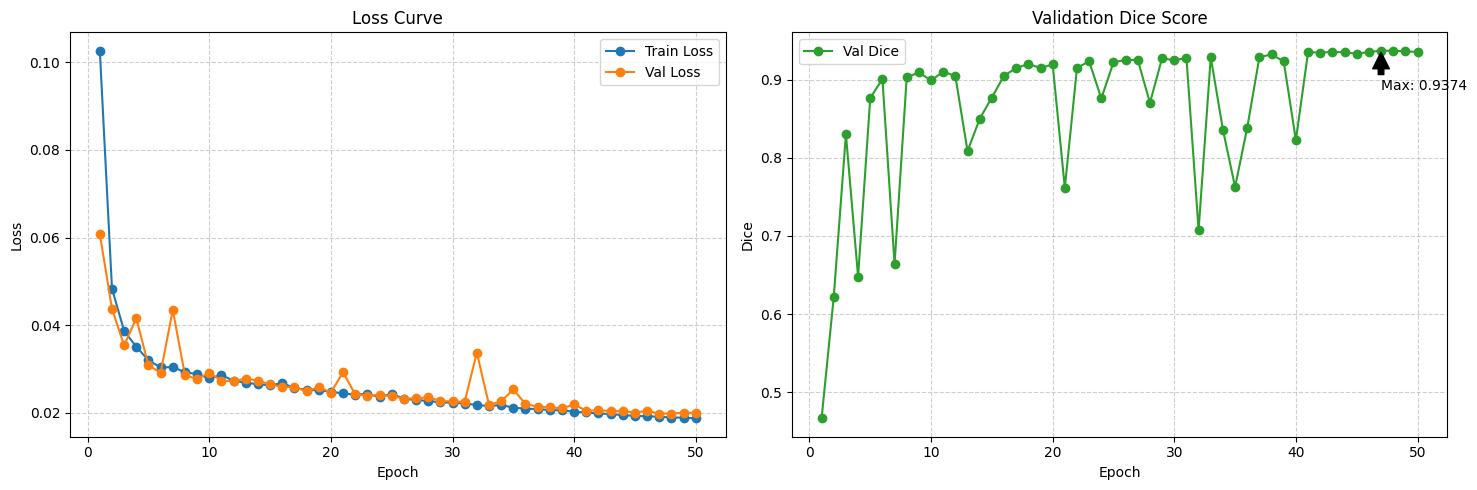

Epoch 50 | T-Loss: 0.0188 | V-Loss: 0.0200 | V-Dice: 0.9358 (Best: 0.9374)
✅ Phase 1 Training Complete!


In [12]:
import time

print("\n" + "="*40)
print("   🚀 START PHASE 1: PRE-TRAINING (ROUGH)")
print("   Target: 5 Classes (Rough Labels)")
print("="*40)
print(f"   📝 log will be saved to: {ROUGH_LOSS_LOG}")


# 1. Setup Data (指定 mode='rough')
train_ds = SliceMasterDataset(train_files, mode='rough', transform=train_transform)
val_ds = SliceMasterDataset(val_files, mode='rough', transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=ROUGH_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_ds, batch_size=ROUGH_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Phase 1 Data: {len(train_ds)} train slices, {len(val_ds)} val slices")

# 2. Setup Model (指定 n_classes=5)
model = ConditionedUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH,   # 5
    n_classes_detail=NUM_CLASSES_DETAILED, # 12
    embed_dim=EMBEDDING_DIM,
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=ROUGH_LR)
class_weights = torch.ones(NUM_CLASSES_ROUGH).to(DEVICE)
criterion_rough = UnifiedMuscleLoss(
    num_classes_rough=NUM_CLASSES_ROUGH,
    num_classes_detail=NUM_CLASSES_DETAILED,
    class_weights_detail=class_weights,
    rough_weight=0.5,        # Rough 任務的權重
    boundary_weight=0.5      # [關鍵] 邊界 Loss 的權重，若邊界還是糊，可調大至 1.0
).to(DEVICE)
scaler = torch.amp.GradScaler("cuda") # 混合精度訓練
# 3. Training Loop
best_dice = 0.0
history_rough = []

for epoch in range(ROUGH_EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0
    
    # [Training]
    # 這裡解包 4 個變數: image, label, z_pos, type_idx
    for images, masks, z_pos, type_idx in tqdm(train_loader, desc=f"Epoch {epoch+1}/{ROUGH_EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
        
        with torch.amp.autocast("cuda"):
            # Forward
            preds = model(images, type_idx, z_pos, return_mode='rough')
            loss = criterion_rough(pred_detailed=None, pred_rough=preds, targets=masks)
            
        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
    
    # [Validation]
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks, z_pos, type_idx in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                preds = model(images, type_idx, z_pos, return_mode='rough')
                loss = criterion_rough(pred_detailed=None, pred_rough=preds, targets=masks)
            
            val_loss += loss.item()
            # 計算 Dice (使用 Cell 2 定義的 function)
            val_dice += dice_score(preds, masks, NUM_CLASSES_ROUGH)
            
    # 計算平均指標
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    
    duration = time.time() - start_time
    
    # 紀錄歷史    
    history_rough.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_dice': avg_val_dice,
        'time': duration
    })
    pd.DataFrame(history_rough).to_csv(ROUGH_LOSS_LOG, index=False)
    
    # [Save Best Model] 關鍵步驟！
    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict, ROUGH_MODEL_PATH)
        print(f"  🏆 Saved Best Model! (Dice: {best_dice:.4f}) -> {ROUGH_MODEL_PATH}")
    
    plot_training_curves(ROUGH_LOSS_LOG, ROUGH_LOSS_IMG)
    print(f"Epoch {epoch+1} | T-Loss: {avg_train_loss:.4f} | V-Loss: {avg_val_loss:.4f} | V-Dice: {avg_val_dice:.4f} (Best: {best_dice:.4f})")

print("✅ Phase 1 Training Complete!")

### 6. Phase 1.5: Hierarchical Warm-up

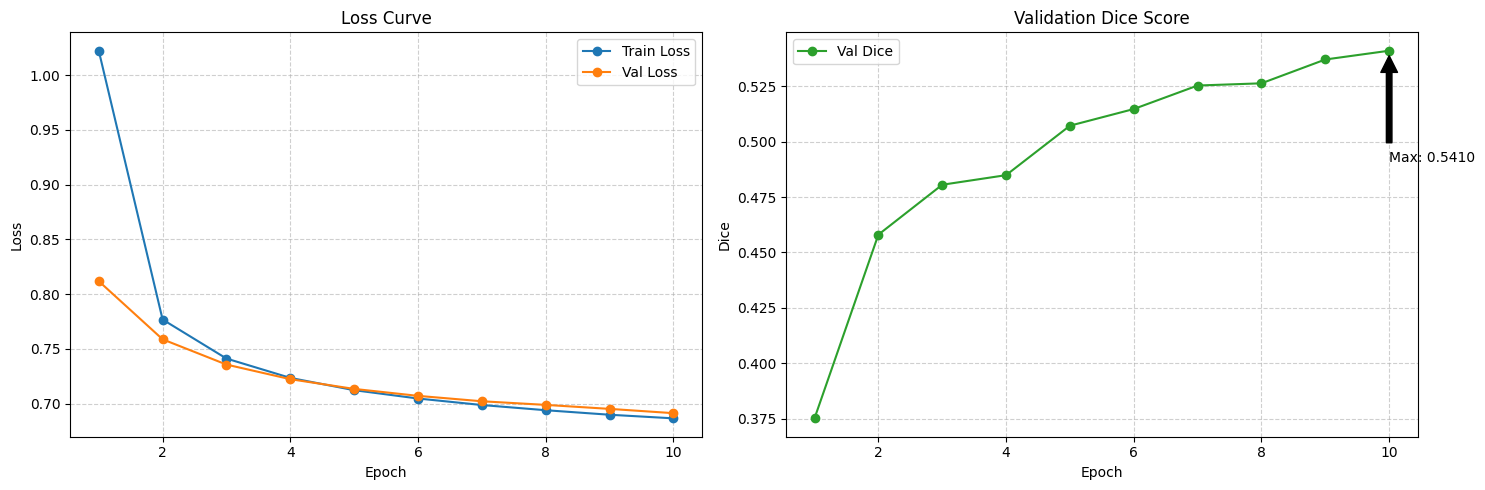

Warmup 10 | Train Loss: 0.6867 | Val Loss: 0.6914 (CE: 0.6913, Consist: 0.0001)
Phase 1.5 Complete. Detail Head Initialized.


In [13]:
print("\n" + "="*40)
print("   🚀 START PHASE 1.5: HIERARCHICAL WARM-UP")
print("   Goal: Train Detail Head to align with Rough Head")
print("="*40)
print(f"   📝 log will be saved to: {WARMUP_LOSS_LOG}")

# 1. 資料過濾 (只用有 Detail 的資料)
print("Filtering detailed data...")
train_files_detail = [f for f in train_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
val_files_detail = [f for f in val_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
print(f"Detail Train: {len(train_files_detail)} | Detail Val: {len(val_files_detail)}")

# Setup Data (Mode='detail')
train_ds_warmup = SliceMasterDataset(train_files_detail, mode='detail', transform=train_transform)
train_loader_warmup = DataLoader(train_ds_warmup, batch_size=WARMUP_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# 驗證集: 不做 Augmentation (transform=None)
val_ds_warmup = SliceMasterDataset(val_files_detail, mode='detail', transform=val_transform)
val_loader_warmup = DataLoader(val_ds_warmup, batch_size=WARMUP_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = ConditionedUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM, 
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

# 3. 載入 Phase 1 權重
model.load_pretrained_encoder(ROUGH_MODEL_PATH)

# 4. 凍結 Encoder 和 Rough Head (老師不准動)
model.freeze_encoder_and_rough()

# 5. 定義帶權重的 Loss (Crucial for AM Muscle!)
# 0:BG, 6:AM -> 加強 AM 權重
warmup_weights = torch.ones(NUM_CLASSES_DETAILED).to(DEVICE)
warmup_weights[6] = 2.0 
criterion_warmup = UnifiedMuscleLoss(
    num_classes_rough=NUM_CLASSES_ROUGH,
    num_classes_detail=NUM_CLASSES_DETAILED,
    class_weights_detail=warmup_weights,
    rough_weight=0.5,        # Rough 任務的權重
    boundary_weight=0.5      # [關鍵] 邊界 Loss 的權重，若邊界還是糊，可調大至 1.0
).to(DEVICE)
# 6. Optimizer (只更新 head_detail)
optimizer_warmup = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=WARMUP_LR)
scaler = torch.amp.GradScaler("cuda") # 混合精度訓練
history_warmup = []

# 7. Training Loop (Warm-up)
print(f"🔥 Starting Warm-up for {WARMUP_EPOCHS} epochs...")
for epoch in range(WARMUP_EPOCHS): # 短暫訓練即可 (e.g., 5-10 epochs)
    model.train()
    train_loss = 0
    train_loss_ce = 0
    train_loss_consist = 0
    
    pbar = tqdm(train_loader_warmup, desc=f"Warm-up Epoch {epoch+1}/{WARMUP_EPOCHS}")
    
    for images, mask_detail, z_pos, type_idx in pbar:
        images, mask_detail = images.to(DEVICE), mask_detail.to(DEVICE)
        z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
        
        with torch.amp.autocast("cuda"):
            # Forward (取得兩組 Logits)
            logits_rough, logits_detail = model(images, type_idx, z_pos, return_mode='both')
            
            # Loss 1: Detailed Head 要預測正確 (Cross Entropy)
            loss_ce = criterion_warmup(pred_detailed=logits_detail, pred_rough=None, targets=mask_detail)
            
            with torch.no_grad():
                # Loss 2: Consistency Constraint (Student -> Teacher)
                # 這裡我們信任 Rough Head 的判斷 (因為它是 Phase 1 訓練好的老師)
                teacher_logits = logits_rough 
            loss_consist = hierarchical_consistency_loss(logits_detail, teacher_logits)
            
            # Total Loss
            loss = loss_ce + 0.5 * loss_consist # 0.5 是權重，可調整
            
        optimizer_warmup.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer_warmup)
        scaler.update()
        
        # 記錄數據
        train_loss += loss.item()
        train_loss_ce += loss_ce.item()
        train_loss_consist += loss_consist.item()
        
        pbar.set_postfix({'L': loss.item(), 'CE': loss_ce.item(), 'C': loss_consist.item()})

    avg_train_loss = train_loss / len(train_loader_warmup)

    # --- [Validation] ---
    model.eval()
    val_loss = 0
    val_loss_ce = 0
    val_loss_consist = 0
    val_dice = 0
    
    with torch.no_grad():
        for images, masks, z_pos, type_idx in val_loader_warmup:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                logits_rough, logits_detail = model(images, type_idx, z_pos, return_mode='both')
                
                l_ce = criterion_warmup(pred_detailed=logits_detail, pred_rough=None, targets=masks)
                l_consist = hierarchical_consistency_loss(logits_detail, logits_rough)
                l_total = l_ce + CONSISTENCY_WEIGHT * l_consist
            
            val_loss += l_total.item()
            val_loss_ce += l_ce.item()
            val_loss_consist += l_consist.item()
            preds = model(images, type_idx, z_pos, return_mode='detail')
            val_dice += dice_score(preds, masks, NUM_CLASSES_DETAILED)
            
    avg_val_loss = val_loss / len(val_loader_warmup)
    avg_val_ce = val_loss_ce / len(val_loader_warmup)
    avg_val_consist = val_loss_consist / len(val_loader_warmup)
    avg_val_dice = val_dice / len(val_loader_warmup)
    
    # 紀錄歷史
    history_warmup.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_ce': avg_val_ce,
        'val_consist': avg_val_consist,
        'val_dice': avg_val_dice
    })
    pd.DataFrame(history_warmup).to_csv(WARMUP_LOSS_LOG, index=False)
    plot_training_curves(WARMUP_LOSS_LOG, WARMUP_LOSS_IMG)
        
    print(f"Warmup {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} (CE: {avg_val_ce:.4f}, Consist: {avg_val_consist:.4f})")

# 存下 Warm-up 後的權重，給 Step 2 用
state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
torch.save(state_dict, WARMUP_MODEL_PATH)
print("Phase 1.5 Complete. Detail Head Initialized.")

### 7. Phase 2: Fine-tune

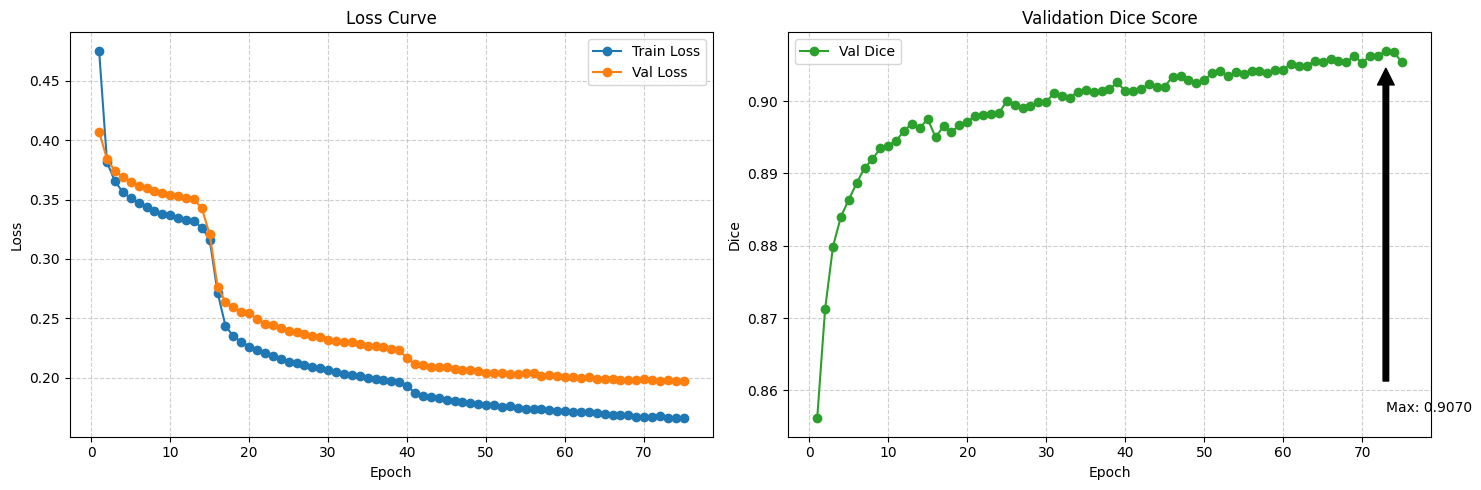

Epoch 75 | T-Loss: 0.1658 | V-Loss: 0.1969 | V-Dice: 0.9054 | Time: 42.5s
Phase 2 Complete.


In [14]:
print("\n" + "="*40)
print("   🚀 START PHASE 2: FINE-TUNING (DETAIL)")
print(f"   Target: {NUM_CLASSES_DETAILED} Classes (Detailed Labels)")
print("="*40)
print(f"   📝 log will be saved to: {DETAIL_LOSS_LOG}")

# ==========================================
# 0. 資料過濾 (Crucial Step!)
# ==========================================
# 我們只訓練那些真正擁有 Detailed Label 的切片
# 這一步會讀取所有 .npy header，可能會花一點時間，但非常有必要
print("🔍 Filtering dataset for detailed labels... (This may take a moment)")

train_files_detail = [f for f in train_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
val_files_detail = [f for f in val_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
print(f"Detailed Train: {len(train_files_detail)} | Detailed Val: {len(val_files_detail)}")

# ==========================================
# 1. Setup Data (Detail Mode)
# ==========================================
train_ds = SliceMasterDataset(train_files_detail, mode='detail', transform=train_transform)
val_ds = SliceMasterDataset(val_files_detail, mode='detail', transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=DETAIL_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_ds, batch_size=DETAIL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# ==========================================
# 2. Setup Model (12 Classes)
# ==========================================
model = ConditionedUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM, 
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

# ==========================================
# 3. Load Pretrained Weights (Surgery)
# ==========================================

if os.path.exists(WARMUP_MODEL_PATH):
    print(f"🔄 Loading pretrained weights from: {WARMUP_MODEL_PATH}")
    model.load_state_dict(torch.load(WARMUP_MODEL_PATH))
    print("✅ Weights loaded from Phase 1.5")
else:
    raise FileNotFoundError(f"❌ Phase 1.5 model not found at {WARMUP_MODEL_PATH}.")

# [關鍵] 全面解凍 (因為 Phase 1.5 結束時是凍結的)
model.unfreeze_all()

# ==========================================
# 4. Optimizer & Weighted Loss
# ==========================================
optimizer = get_fine_tuning_optimizer(model, encoder_lr=DETAIL_LR_ENCODER, decoder_lr=DETAIL_LR_DECODER)
# [關鍵策略] Class Weighting
# 因為 AM (Class 6) 之前被當作背景，我們要給它更高的權重，強迫模型關注它
# 0:BG, 1:SA, ..., 6:AM, ...
class_weights = torch.ones(NUM_CLASSES_DETAILED).to(DEVICE)
class_weights[0] = 0.5  # Background 降權
class_weights[6] = 3.0  # AM (最難切，給最高權重)
class_weights[1] = 2.5  # Sar (細長表淺)
class_weights[7] = 2.5  # Gra (細長帶狀)
class_weights[9] = 2.0  # BFSH (表現稍弱)

criterion_detail = UnifiedMuscleLoss(
    num_classes_rough=NUM_CLASSES_ROUGH,
    num_classes_detail=NUM_CLASSES_DETAILED,
    class_weights_detail=class_weights,
    rough_weight=0.5,        # Rough 任務的權重
    boundary_weight=0.5      # [關鍵] 邊界 Loss 的權重，若邊界還是糊，可調大至 1.0
).to(DEVICE)

scaler = torch.amp.GradScaler("cuda") # 混合精度訓練

# ==========================================
# 5. Training Loop
# ==========================================
best_dice = 0.0
history_detail = []
print(f"Start Fine-tuning for {DETAIL_EPOCHS} epochs...")

for epoch in range(DETAIL_EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0
    
    # [Training]
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{DETAIL_EPOCHS}")
    
     # 這裡解包 4 個變數: image, label, z_pos, type_idx
    for images, masks, z_pos, type_idx in pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
        
        with torch.amp.autocast("cuda"):
            preds = model(images, type_idx, z_pos, return_mode='detail')
            loss = criterion_detail(pred_detailed=preds, pred_rough=None, targets=masks)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        
    # [Validation]
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks, z_pos, type_idx in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
                        
            with torch.amp.autocast("cuda"):
                preds = model(images, type_idx, z_pos, return_mode='detail')
                loss = criterion_detail(pred_detailed=preds, pred_rough=None, targets=masks)
            
            val_loss += loss.item()
            # 這裡計算 12 類的 Dice
            val_dice += dice_score(preds, masks, NUM_CLASSES_DETAILED)
            
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    
    duration = time.time() - start_time
    # 紀錄歷史
    history_detail.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_dice': avg_val_dice,
        'time': duration
    })
    pd.DataFrame(history_detail).to_csv(DETAIL_LOSS_LOG, index=False)
    plot_training_curves(DETAIL_LOSS_LOG, DETAIL_LOSS_IMG)
    print(f"Epoch {epoch+1} | T-Loss: {avg_train_loss:.4f} | V-Loss: {avg_val_loss:.4f} | V-Dice: {avg_val_dice:.4f} | Time: {duration:.1f}s")
    
    
    # [Save Best]
    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict, DETAIL_MODEL_PATH)
        print(f"  🏆 Saved Best Detail Model! (Dice: {best_dice:.4f})")

print("Phase 2 Complete.")

### 8. Test

Found 724 slices in Test Set.
  - With Detailed Labels: 618 slices
  - Without Detailed Labels: 106 slices
🔄 Loading weights from: /home/n26141826/114-1_TAICA_cv_Final_Project/checkpoints/checkpoints_3step_256_hybridLoss/detail_model_best.pth
🚀 Starting Inference on Test Set...


100%|██████████| 618/618 [00:02<00:00, 237.51it/s]



   Test Set Evaluation Report (Dice Score)
數值為 Mean Dice Score:


,Fat,STIR,T1,T2,Water
Adductor Magnus,0.8221,0.7367,0.8299,0.8044,0.8005
Biceps Femoris LH,0.8187,0.7649,0.8678,0.7882,0.7866
Biceps Femoris SH,0.8141,0.7330,0.8327,0.8126,0.7946
Gracilis,0.8572,0.6629,0.8513,0.8184,0.8044
Rectus Femoris,0.8231,0.5648,0.8402,0.8349,0.8620
Sartorius,0.8558,0.7505,0.8769,0.8603,0.8385
Semimembranosus,0.7748,0.7316,0.8350,0.7398,0.7511
Semitendinosus,0.7727,0.7050,0.8194,0.7896,0.7436
Vastus Intermedius,0.7787,0.7918,0.8598,0.8001,0.8010
Vastus Lateralis,0.8429,0.8159,0.8915,0.8542,0.8574



評估表已儲存至: /home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_256_hybridLoss/evaluation_metrics_per_sequence.csv

Sampled every 50 slices from Test Set


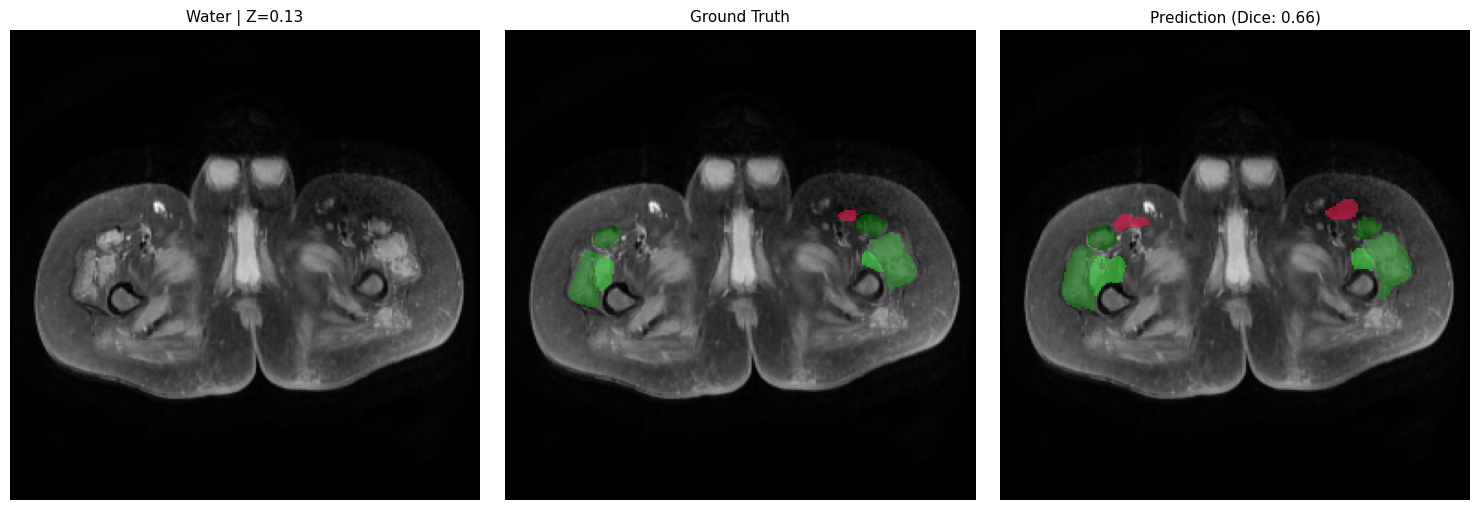

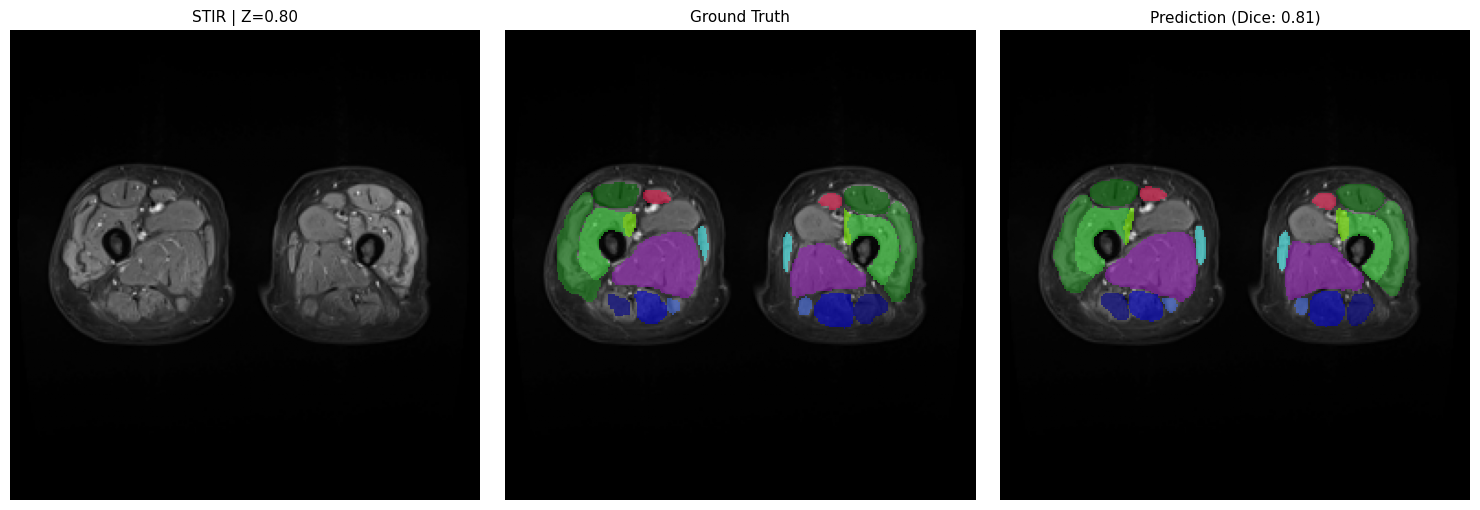

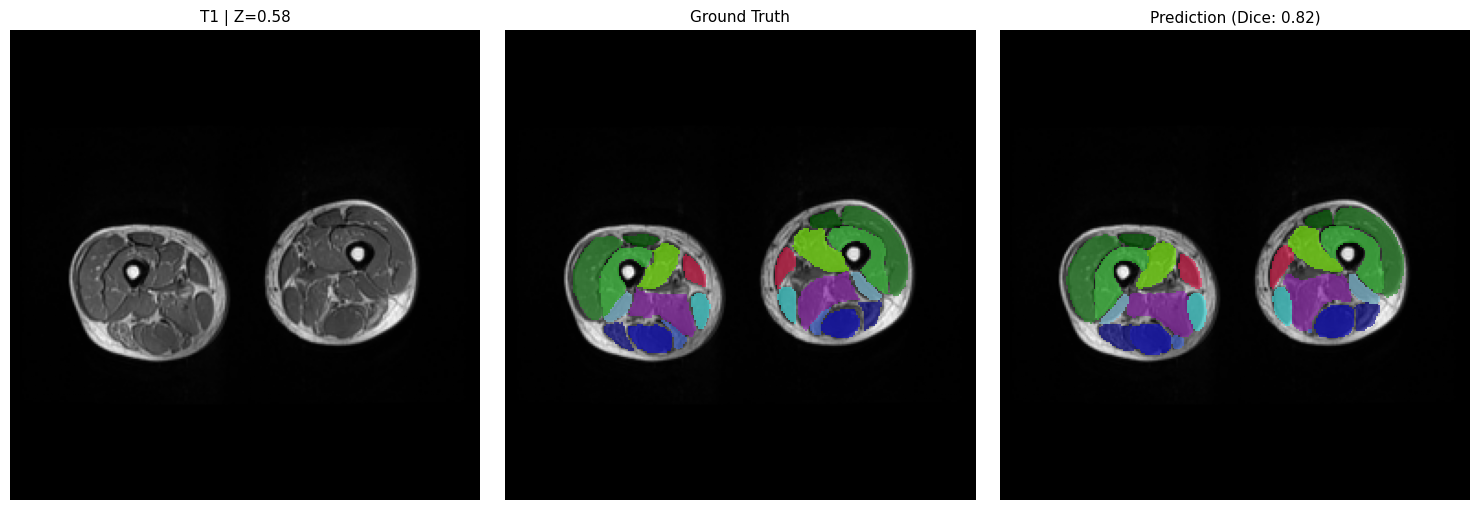

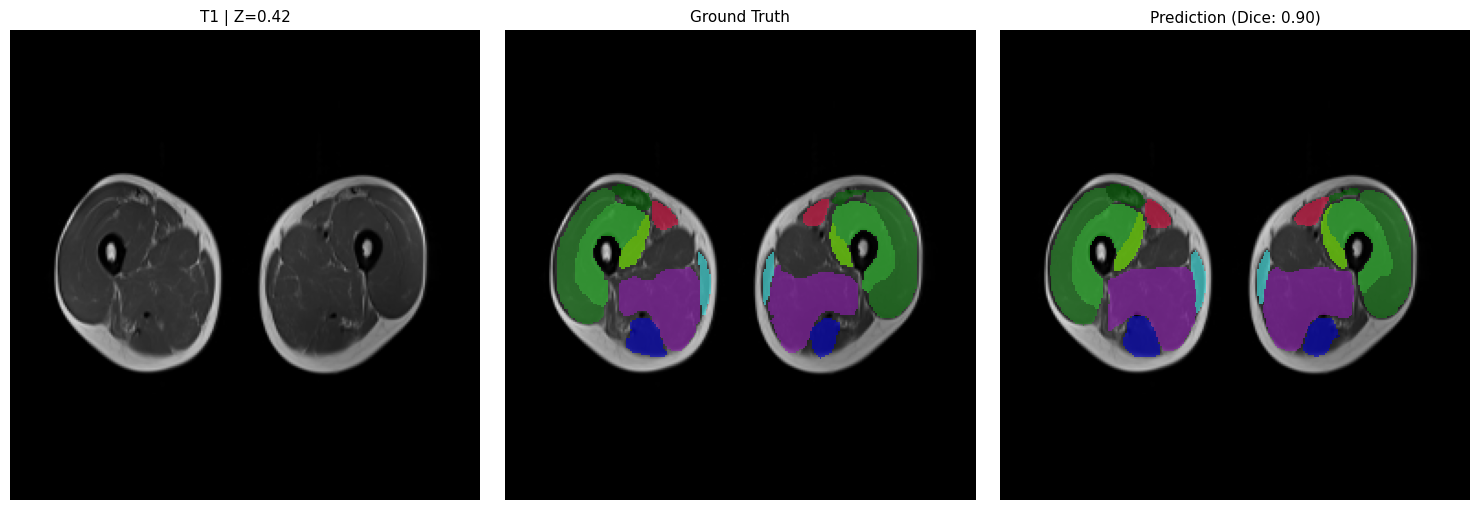

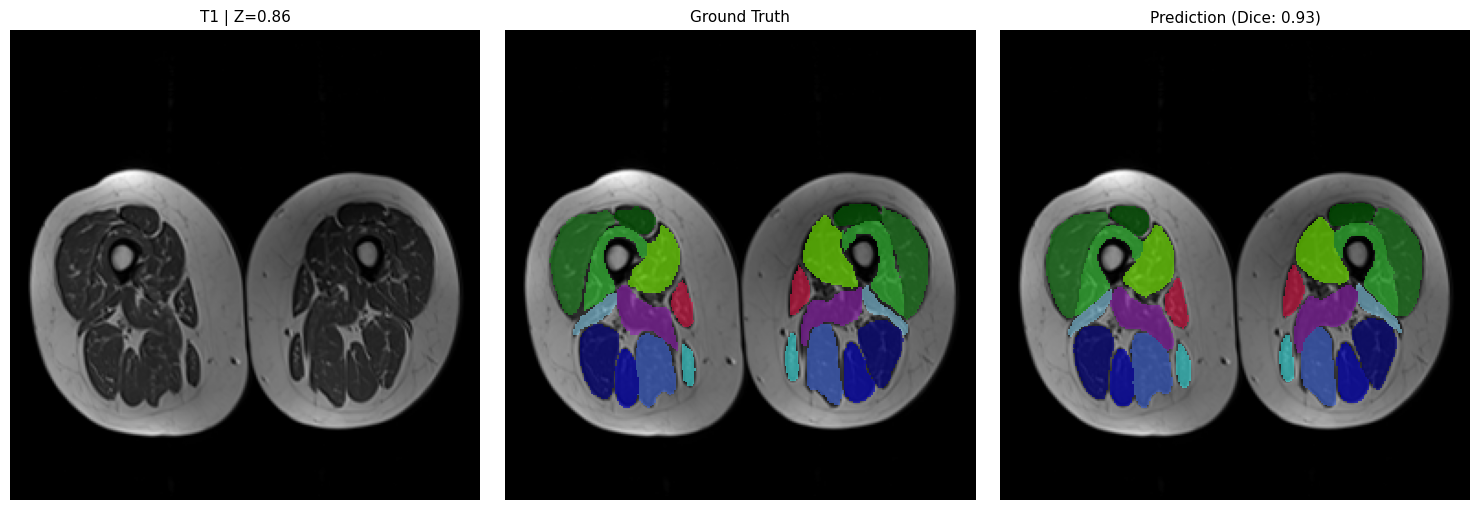

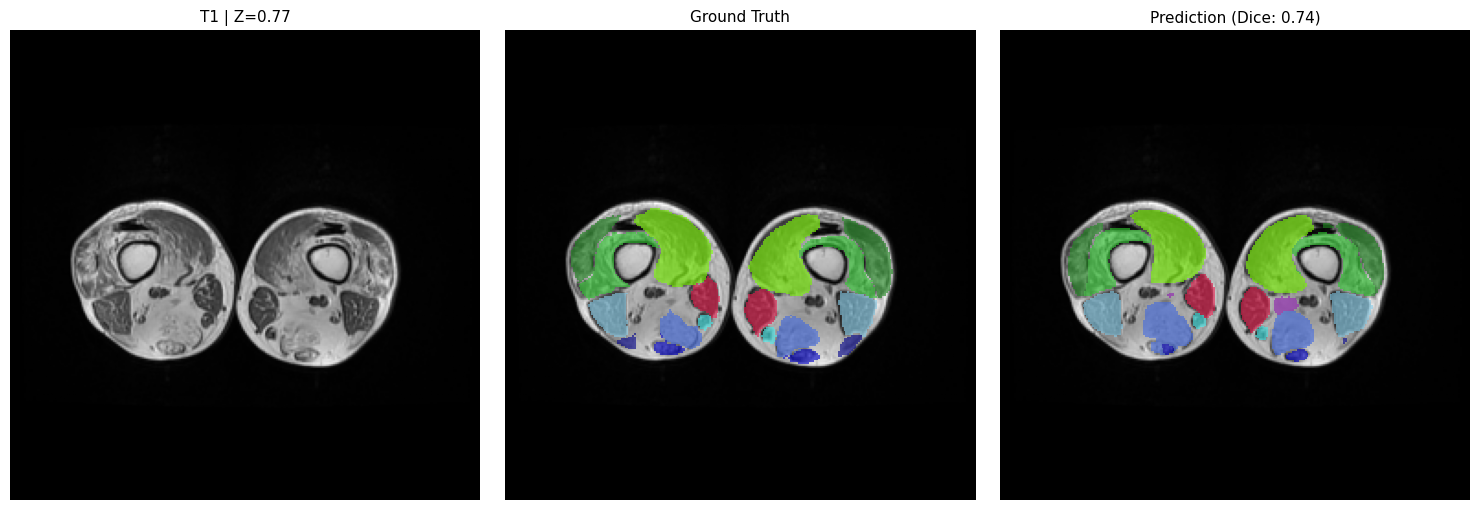

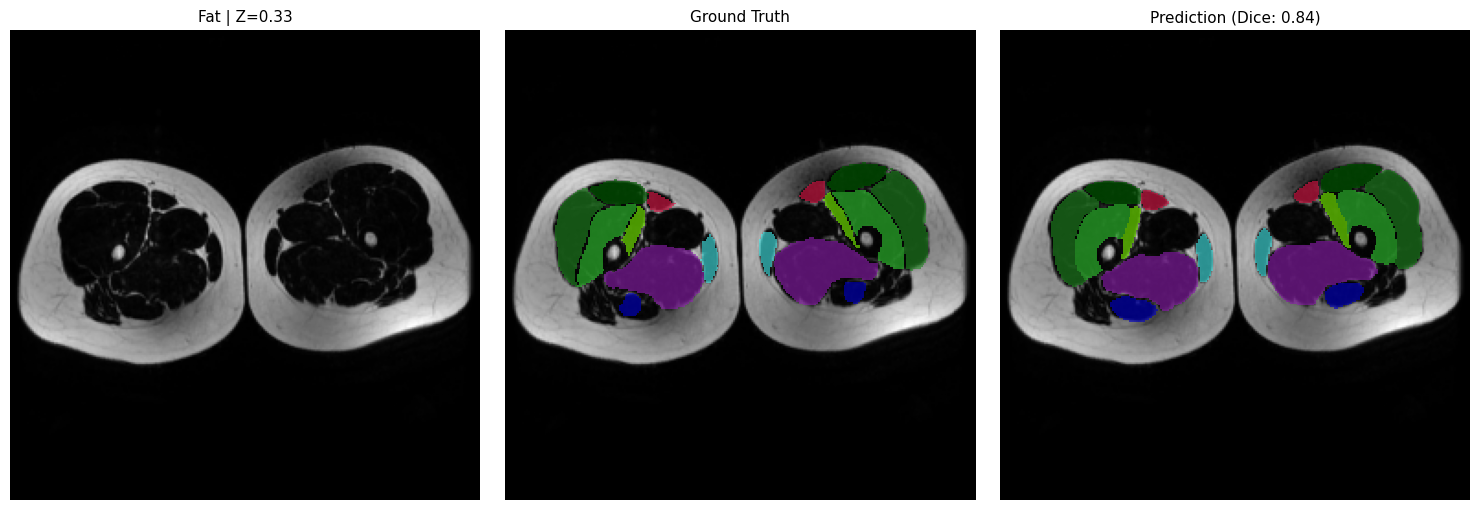

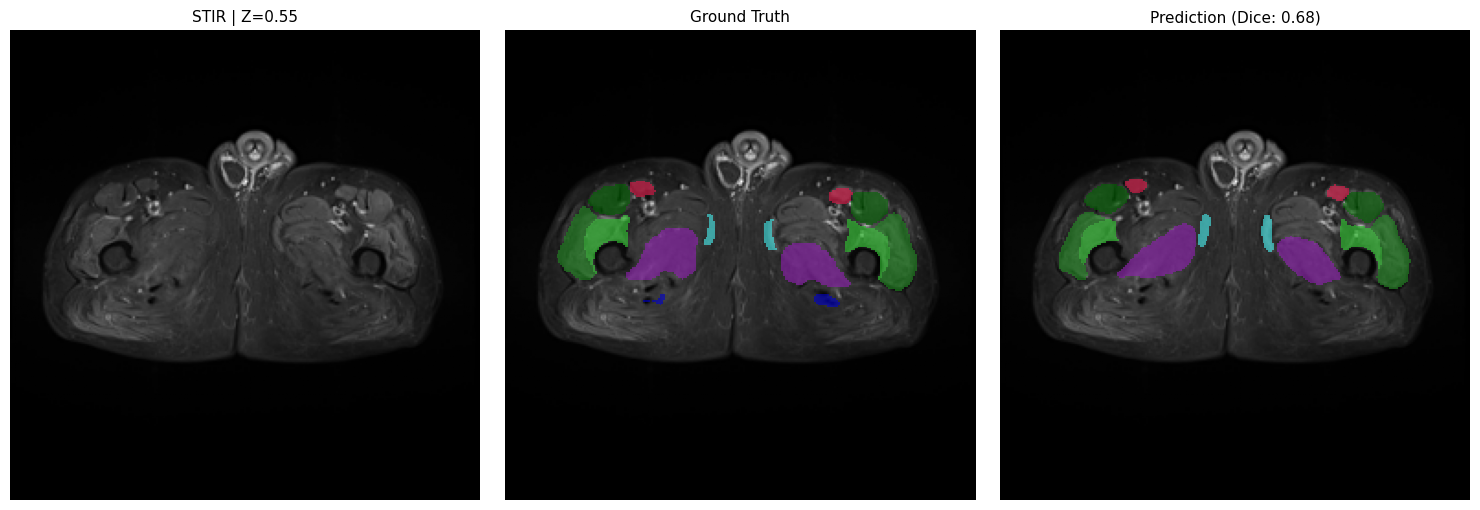

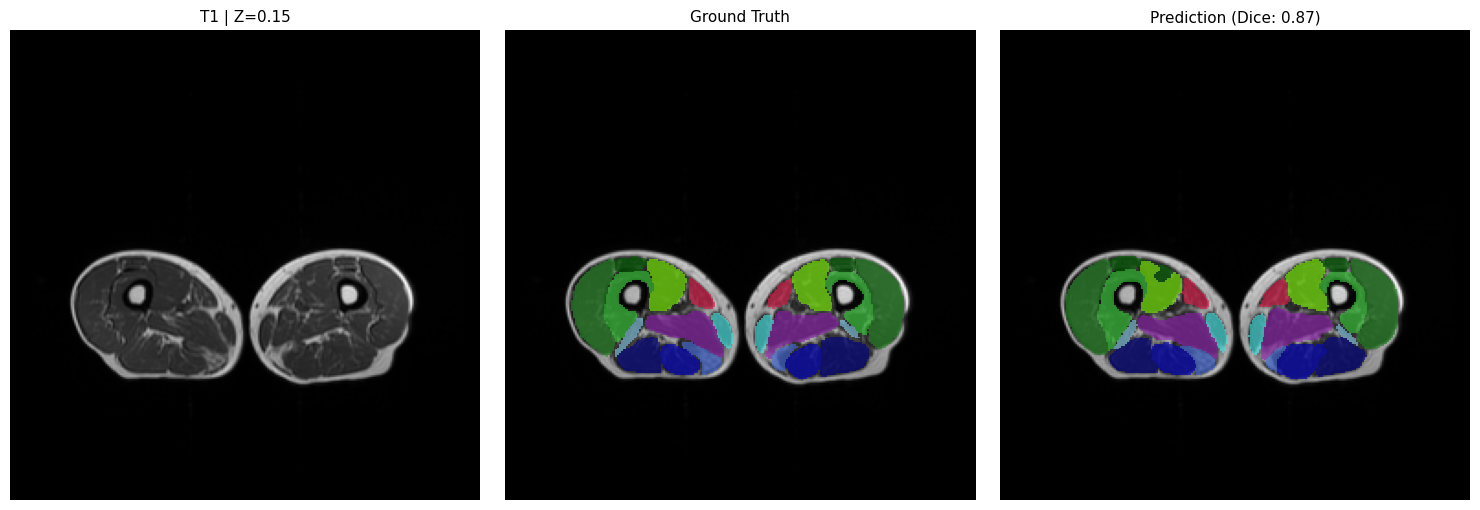

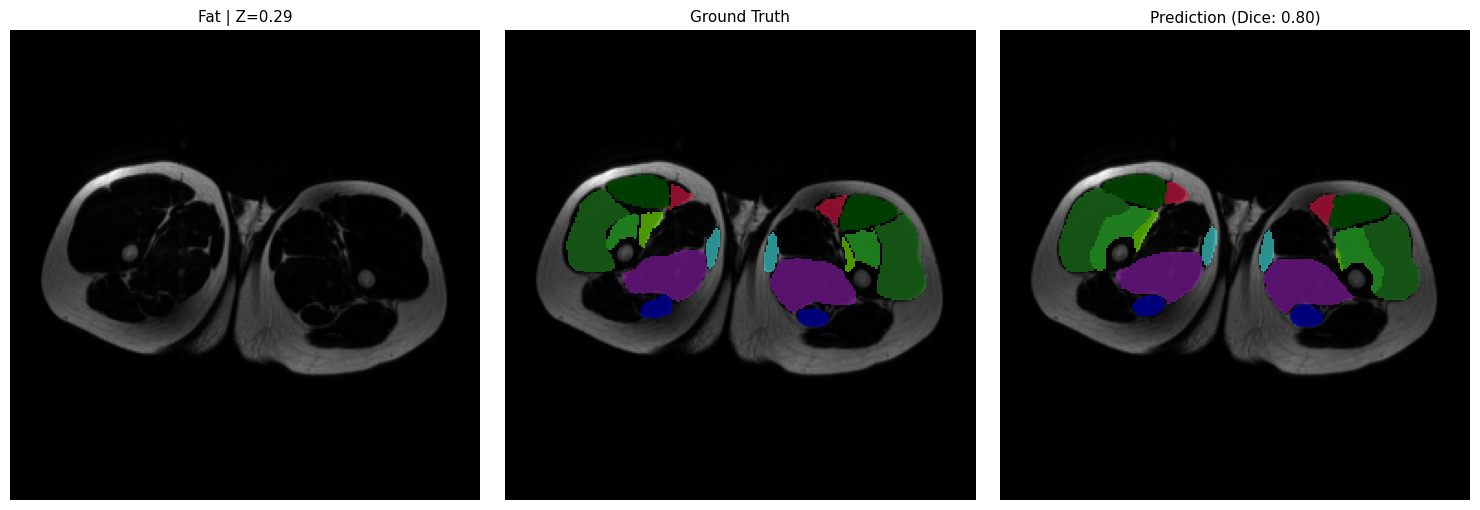

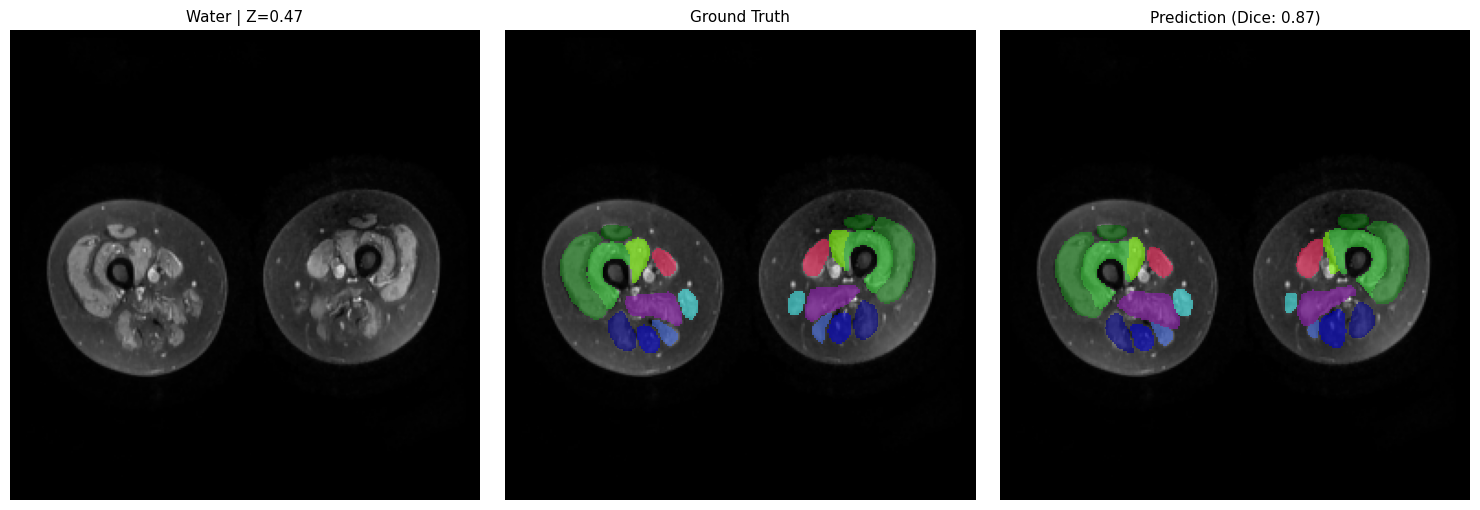

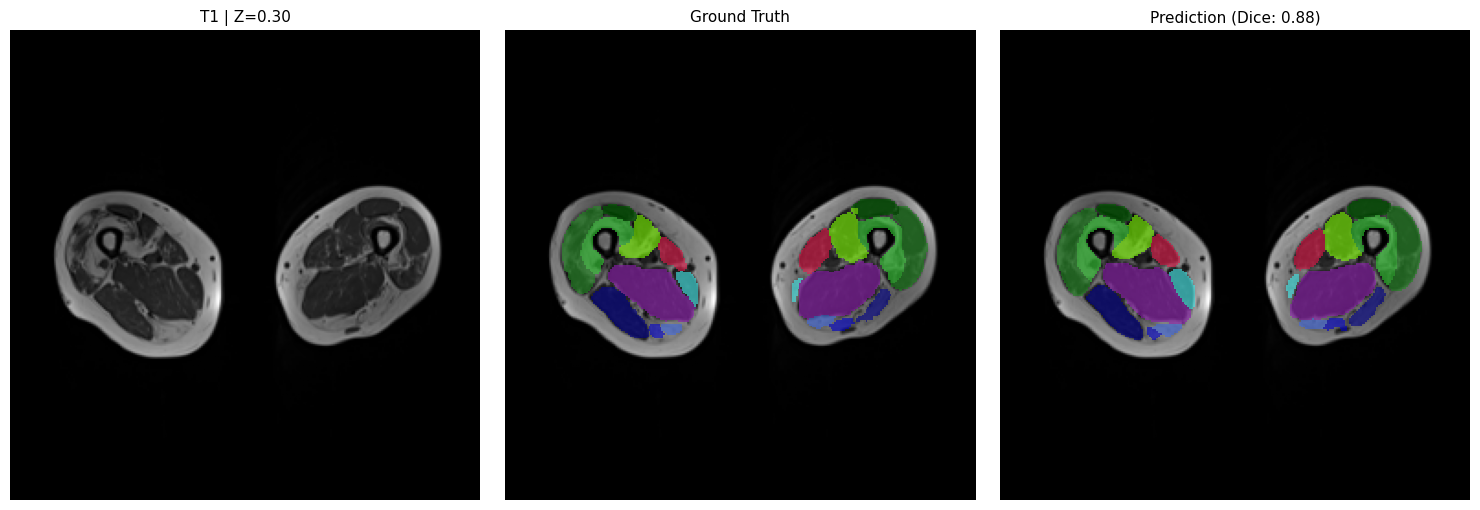

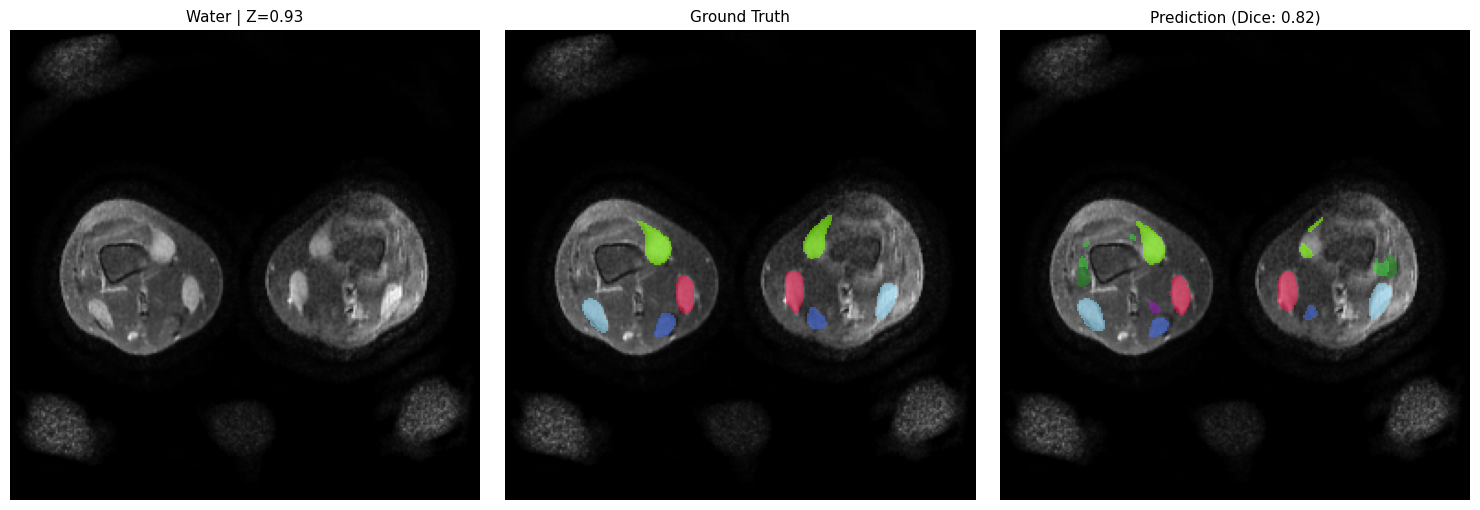

In [15]:
test_files = glob.glob(os.path.join(TEST_DATA_DIR, "*.npy"))
if len(test_files) == 0:
    raise FileNotFoundError(f"❌ No .npy files found in {TEST_DATA_DIR}. Please check the path!")

print(f"Found {len(test_files)} slices in Test Set.")
test_detail = []
test_without_detail = []
for i in test_files:
    data = np.load(i, allow_pickle=True).item()
    if data.get('has_detail'):
        test_detail.append(i)
    else:
        test_without_detail.append(i)
print(f"  - With Detailed Labels: {len(test_detail)} slices")
print(f"  - Without Detailed Labels: {len(test_without_detail)} slices")
        
# 建立 Dataset 與 Loader
# 注意: mode='detail', transform=None (測試集不做增強)
test_ds = SliceMasterDataset(test_detail, mode='detail', transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ==========================================
# 2. 載入模型
# ==========================================
model = ConditionedUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM,
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

if os.path.exists(EVAL_MODEL_PATH):
    print(f"🔄 Loading weights from: {EVAL_MODEL_PATH}")
    state_dict = torch.load(EVAL_MODEL_PATH, map_location=DEVICE, weights_only=False)
    model.load_state_dict(state_dict)
else:
    raise FileNotFoundError(f"❌ Model weight not found at {EVAL_MODEL_PATH}")
model.eval()

# ================= 3. 推論與數據收集 =================
# 儲存結構: metrics[Sequence][Muscle_ID] = [dice1, dice2, ...]
metrics_data = defaultdict(lambda: defaultdict(list))
viz_results = []  # 儲存要畫圖的資料
print("🚀 Starting Inference on Test Set...")

with torch.no_grad():
    for idx, (images, labels, z_pos, type_idx) in enumerate(tqdm(test_loader)):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        z_pos = z_pos.to(DEVICE)
        type_idx = type_idx.to(DEVICE)
        
        # 取得當前的 MRI Type ID
        current_type_id = type_idx.item()
        
        # 推論 (return_mode='detail')
        with torch.amp.autocast("cuda"):
            out_det = model(images, type_idx, z_pos, return_mode='detail')
        
        pred_det = torch.argmax(out_det, dim=1)
        
        # --- 計算每個肌肉的 Dice 並存起來 ---
        slice_dices = []
        for c in range(1, NUM_CLASSES_DETAILED): # 1~11 (Skip BG)
            pred_mask = (pred_det == c)
            true_mask = (labels == c)
            
            inter = (pred_mask & true_mask).sum().item()
            union = (pred_mask.sum() + true_mask.sum()).item()
            
            # 只有當 GT 有該肌肉時才納入統計
            if true_mask.sum() > 0:
                dice_val = 2 * inter / (union + 1e-6)
                metrics_data[current_type_id][c].append(dice_val)
                slice_dices.append(dice_val)
            
        # --- 收集視覺化資料 (隨機抽樣) ---
        if idx % VIZ_INTERVAL == 0:
            avg_slice_dice = np.mean(slice_dices) if slice_dices else 0.0
            type_name = ID_TO_TYPE.get(current_type_id, str(current_type_id))
            
            viz_results.append({
                'type_name': type_name,
                'z': z_pos.item(),
                'img': images[0, 0].cpu().numpy(),
                'gt': labels[0].cpu().numpy(),
                'pred': pred_det[0].cpu().numpy(),
                'dice': avg_slice_dice
            })

# ================= 4. 產生報表 =================
# Rows: Muscle Names, Cols: Sequences

print("\n" + "="*40)
print("   Test Set Evaluation Report (Dice Score)")
print("="*40)

final_table = {}
all_types_in_data = sorted(metrics_data.keys())

for c in range(1, NUM_CLASSES_DETAILED):
    muscle_name = MUSCLE_NAMES.get(c, f"Muscle_{c}")
    row_data = {}
    for t_id in all_types_in_data:
        dices = metrics_data[t_id][c]
        mean_dice = np.mean(dices) if dices else 0.0
        
        col_name = ID_TO_TYPE.get(t_id, str(t_id))
        row_data[col_name] = mean_dice
    final_table[muscle_name] = row_data

df_metrics = pd.DataFrame(final_table).T 
df_metrics = df_metrics.sort_index()

# 重新排序欄位
target_order = ['Fat', 'STIR', 'T1', 'T2', 'Water']
df_metrics = df_metrics.reindex(columns=target_order)  

# 加入平均
df_metrics.loc['AVERAGE'] = df_metrics.mean()

# 顯示漂亮的表格
pd.options.display.float_format = '{:.4f}'.format
print("數值為 Mean Dice Score:")
display(df_metrics)

# 存檔
df_metrics.to_csv(EVAL_CSV_OUTPUT)
print(f"\n評估表已儲存至: {EVAL_CSV_OUTPUT}")

# ================= 5. 視覺化展示 =================
if viz_results:
    print("\n" + "="*40)
    # print(f"   個案切片視覺化 (First / Middle / Last)")
    print(f"Sampled every {VIZ_INTERVAL} slices from Test Set")
    print("="*40)

    for item in viz_results:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        title_fs = 11
        
        # Raw Image
        axs[0].imshow(item['img'], cmap='gray')
        axs[0].set_title(f"{item['type_name']} | Z={item['z']:.2f}", fontsize=title_fs)
        axs[0].axis('off')
        
        # Ground Truth
        axs[1].imshow(item['img'], cmap='gray')
        axs[1].imshow(item['gt'], cmap=VIZ_CMAP, norm=VIZ_NORM, alpha=0.6, interpolation='nearest')
        axs[1].set_title("Ground Truth", fontsize=title_fs)
        axs[1].axis('off')
        
        # Prediction
        axs[2].imshow(item['img'], cmap='gray')
        axs[2].imshow(item['pred'], cmap=VIZ_CMAP, norm=VIZ_NORM, alpha=0.6, interpolation='nearest')
        axs[2].set_title(f"Prediction (Dice: {item['dice']:.2f})", fontsize=title_fs)
        axs[2].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("No visualization samples generated. Check VIZ_INTERVAL or data size.")

In [16]:
import pandas as pd

df_metrics = pd.read_csv(EVAL_CSV_OUTPUT, index_col=0)

print(df_metrics.index)

avg_row = df_metrics.loc[['AVERAGE']]

other_rows = df_metrics.drop('AVERAGE')

df_metrics = pd.concat([avg_row, other_rows])

flat = df_metrics.stack()  # 變成 MultiIndex Series (row, col)
flat.index = [f"{row}_{col}" for row, col in flat.index]  # 合併名稱
flat_df = flat.to_frame().T  # 轉成一列 DataFrame

flat_df.to_csv(FLATTENED_METRICS_OUTPUT, index=False)
print(f"Flattened metrics saved to '{FLATTENED_METRICS_OUTPUT}'")

Index(['Adductor Magnus', 'Biceps Femoris LH', 'Biceps Femoris SH', 'Gracilis',
       'Rectus Femoris', 'Sartorius', 'Semimembranosus', 'Semitendinosus',
       'Vastus Intermedius', 'Vastus Lateralis', 'Vastus Medialis', 'AVERAGE'],
      dtype='object')
Flattened metrics saved to '/home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_256_hybridLoss/flattened_metrics.csv'
